In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
# change to your data path if necessary
DATA_DIR = Path('data')
path = DATA_DIR / 'bbc'
files = sorted(list(path.glob('**/*.txt')))

doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [3]:
train_docs, test_docs = train_test_split(docs, stratify=docs.Category, test_size=50, random_state=42)
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [4]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: Category, dtype: int64

In [5]:
# Vectorize train & test sets
vectorizer = TfidfVectorizer(max_df=.25, min_df=.01, stop_words='english', binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

<2175x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 210043 stored elements in Compressed Sparse Row format>

In [6]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 4758 stored elements in Compressed Sparse Row format>

In [7]:
# Get token count
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film          41.256270
government    38.808175
game          36.319726
best          36.093477
uk            36.082515
labour        32.496474
music         30.706548
000           30.276350
company       29.549555
number        29.153795
dtype: float64

In [8]:
# Latent Semantic Analysis
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]
svd = TruncatedSVD(n_components=n_components, n_iter=5, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(n_components=5, random_state=42)

In [9]:
svd.singular_values_

array([8.90935604, 5.71762755, 5.38197939, 5.04420678, 4.71440144])

In [10]:
svd.explained_variance_ratio_.sum()

0.05382357286057268

In [11]:
train_doc_topics = svd.transform(train_dtm)
train_doc_topics.shape

(2175, 5)

In [12]:
# Topic Weights for sample article
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], index=topic_labels)))

Category                             Business
Heading     Rich grab half Colombia poor fund
Topic 1                              0.178105
Topic 2                              0.113584
Topic 3                             -0.012381
Topic 4                             -0.034268
Topic 5                             -0.047526
dtype: object

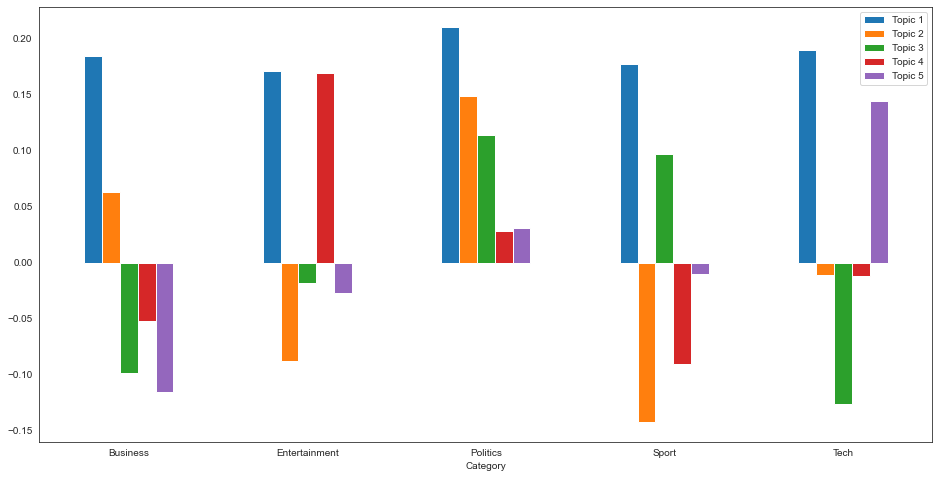

In [13]:
# Average topic weight per category
train_result = pd.DataFrame(data=train_doc_topics, columns=topic_labels, index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar(figsize=(16, 8), rot=0);

In [14]:
# Topics weights of most frequent words
topics = pd.DataFrame(svd.components_.T, index=tokens, columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.096117,-0.157755,-0.037131,0.456760,-0.108419
government,0.105821,0.158542,0.050579,0.000476,-0.032035
game,0.092472,-0.165604,0.074222,-0.112915,0.056594
best,0.088036,-0.148498,0.019054,0.264735,-0.091923
uk,0.092431,0.030233,-0.055868,0.041345,0.012776
labour,0.100164,0.237937,0.227080,0.071624,0.054642
music,0.078805,-0.050253,-0.114264,0.080930,0.140046
000,0.073360,0.029985,-0.044699,0.003032,-0.013678
company,0.067638,0.024084,-0.102071,-0.028465,-0.053378
number,0.070099,-0.039725,-0.019470,0.030363,0.003596


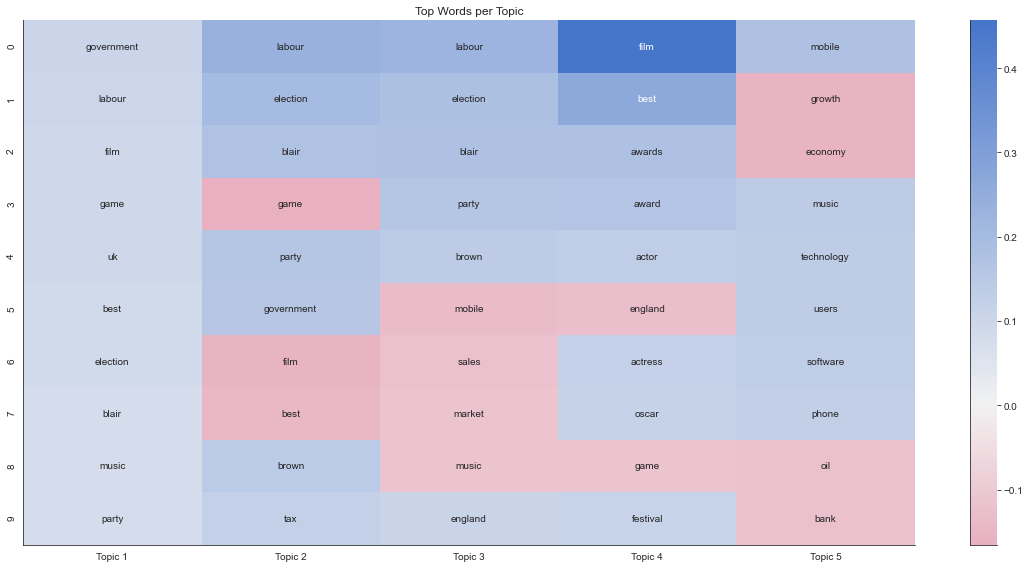

In [15]:
# Most important words by topic
fig, ax = plt.subplots(figsize=(16, 8))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.abs().nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals), annot=top_words, fmt='', center=0,
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), ax=ax)
ax.set_title('Top Words per Topic')
sns.despine()
fig.tight_layout()

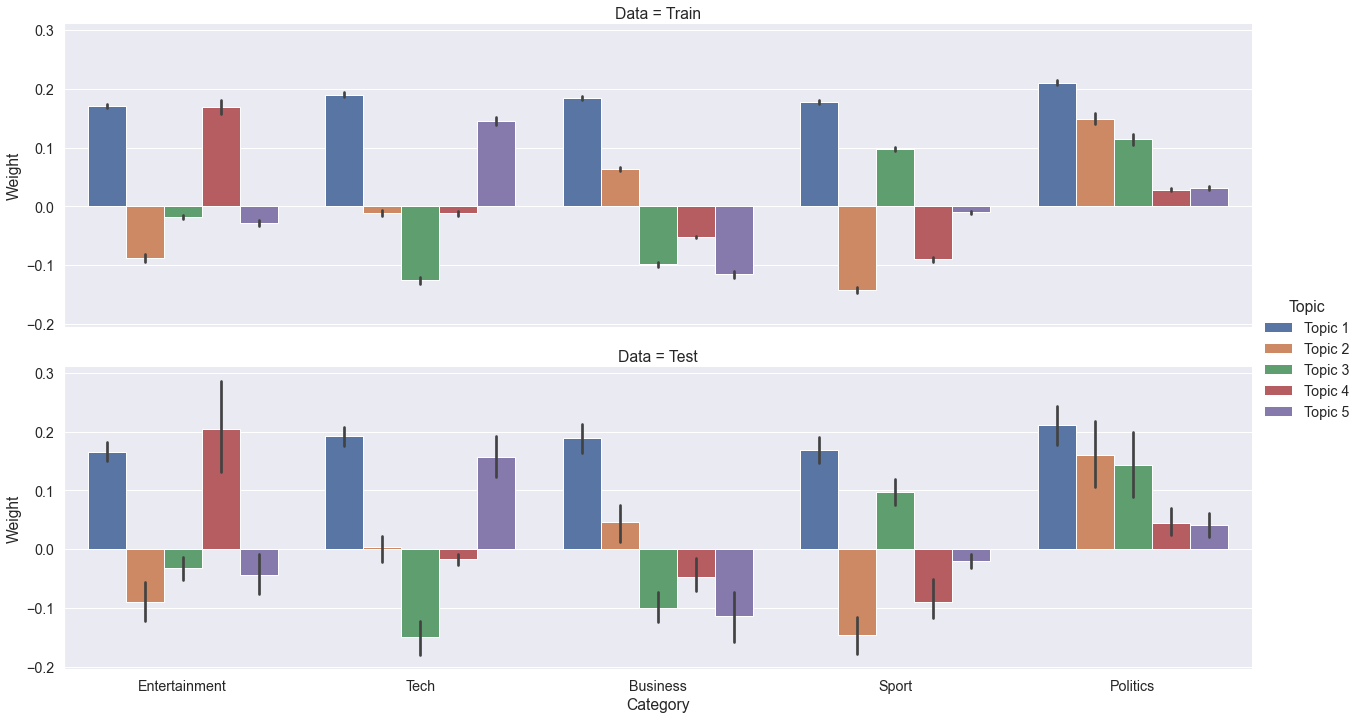

In [16]:
# Topics weights for test set
test_eval = pd.DataFrame(data=svd.transform(test_dtm), columns=topic_labels, index=test_docs.Category)
sns.set(font_scale=1.3)
result = pd.melt(train_result.assign(Data='Train').append(test_eval.assign(Data='Test')).reset_index(),
                 id_vars=['Data', 'Category'], var_name='Topic', value_name='Weight')

g = sns.catplot(x='Category', y='Weight', hue='Topic', row='Data', kind='bar', data=result, aspect=3.5);

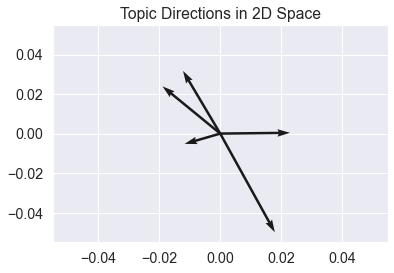

In [17]:
# Categories in 2D
pca = PCA(n_components=2)
svd2d = pd.DataFrame(pca.fit_transform(train_result), columns=['PC1',
                              'PC2']).assign(Category=train_docs.Category)
categories_2d = svd2d.groupby('Category').mean()
plt.quiver(np.zeros(5), np.zeros(5), categories_2d.PC1.values, categories_2d.PC2.values, scale=.035)
plt.title('Topic Directions in 2D Space');